This should just be a short notebook showing some of the properties of the adaptive dropout parameters that we can learn with this method.

In [2]:
import varout.layers
import varout.objectives
import varout.experiments
import lasagne.layers
import lasagne.nonlinearities
import lasagne.init
import theano
import theano.tensor as T
import numpy as np
import holonets
import holoviews as hv
%load_ext holoviews.ipython

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K40c (CNMeM is disabled)


In [3]:
dataset = varout.experiments.load_data()

In [9]:
batch_size, input_dim, n_hidden, output_dim = 200, 784, 100, 10
l_in = lasagne.layers.InputLayer((batch_size, input_dim))
l_drop1 = varout.layers.VariationalDropoutA(l_in, p=0.2, adaptive='elementwise')
l_hidden1 = lasagne.layers.DenseLayer(l_drop1, num_units=n_hidden)
l_drop2 = varout.layers.VariationalDropoutA(l_hidden1, p=0.5, adaptive='elementwise')
l_hidden2 = lasagne.layers.DenseLayer(l_drop2, num_units=n_hidden)
l_drop3 = varout.layers.VariationalDropoutA(l_hidden2, p=0.5, adaptive='elementwise')
l_hidden3 = lasagne.layers.DenseLayer(l_drop3, num_units=n_hidden)
l_drop4 = varout.layers.VariationalDropoutA(l_hidden3, p=0.5, adaptive='elementwise')
l_out = lasagne.layers.DenseLayer(l_drop4, num_units=output_dim,
                                      nonlinearity=lasagne.nonlinearities.softmax)

In [10]:
def set_up_training(l_out, dataset, squash_updates=False, N_train=50000, N_test=10000):
    expressions = holonets.monitor.Expressions(l_out, dataset, update_rule=lasagne.updates.adam,
                                              loss_function=lasagne.objectives.categorical_crossentropy,
                                              loss_aggregate=T.mean, 
                                              extra_loss=-varout.objectives.priorKL(l_out)/N_train,
                                              learning_rate=0.001)
    # add channel to monitor loss and accuracy on training and test
    expressions.add_channel(**expressions.loss('train', False))
    expressions.add_channel(**expressions.accuracy('train', False))
    expressions.add_channel(**expressions.loss('test', True))
    expressions.add_channel(**expressions.accuracy('test', True))
    expressions.add_channel(name='cross-entropy loss', dimension='Loss',
                            expression=T.mean(
            lasagne.objectives.categorical_crossentropy(expressions.network_output, expressions.y_batch)),
                            function='train')
    expressions.add_channel(name='DKL', dimension='Loss', 
                            expression=-varout.objectives.priorKL(l_out)/N_train, function='train')
    # would like to track the various alphas
    for i, dlayer in enumerate([l for l in lasagne.layers.get_all_layers(l_out) 
                   if isinstance(l, varout.layers.VariationalDropout)]):
        expressions.add_channel(name='Dropout Layer {0} Mean Alpha'.format(i+1),
                                dimension='Alpha', function='train',
                                expression=T.mean(T.nnet.sigmoid(dlayer.logitalpha)))
        expressions.add_channel(name='Dropout Layer {0} Sigma Alpha'.format(i+1),
                                dimension='Alpha', function='train',
                                expression=T.sqrt(T.var(T.nnet.sigmoid(dlayer.logitalpha))))
    channels = expressions.build_channels()
    train = holonets.train.Train(channels, n_batches={'train': N_train//batch_size,
                                                      'test': N_test//batch_size})
    loop = holonets.run.EpochLoop(train, dimensions=train.dimensions)
    return loop

In [11]:
loop = set_up_training(l_out, dataset)

:NdLayout   [Channel]
   :Curve   [Epoch]   (Loss)
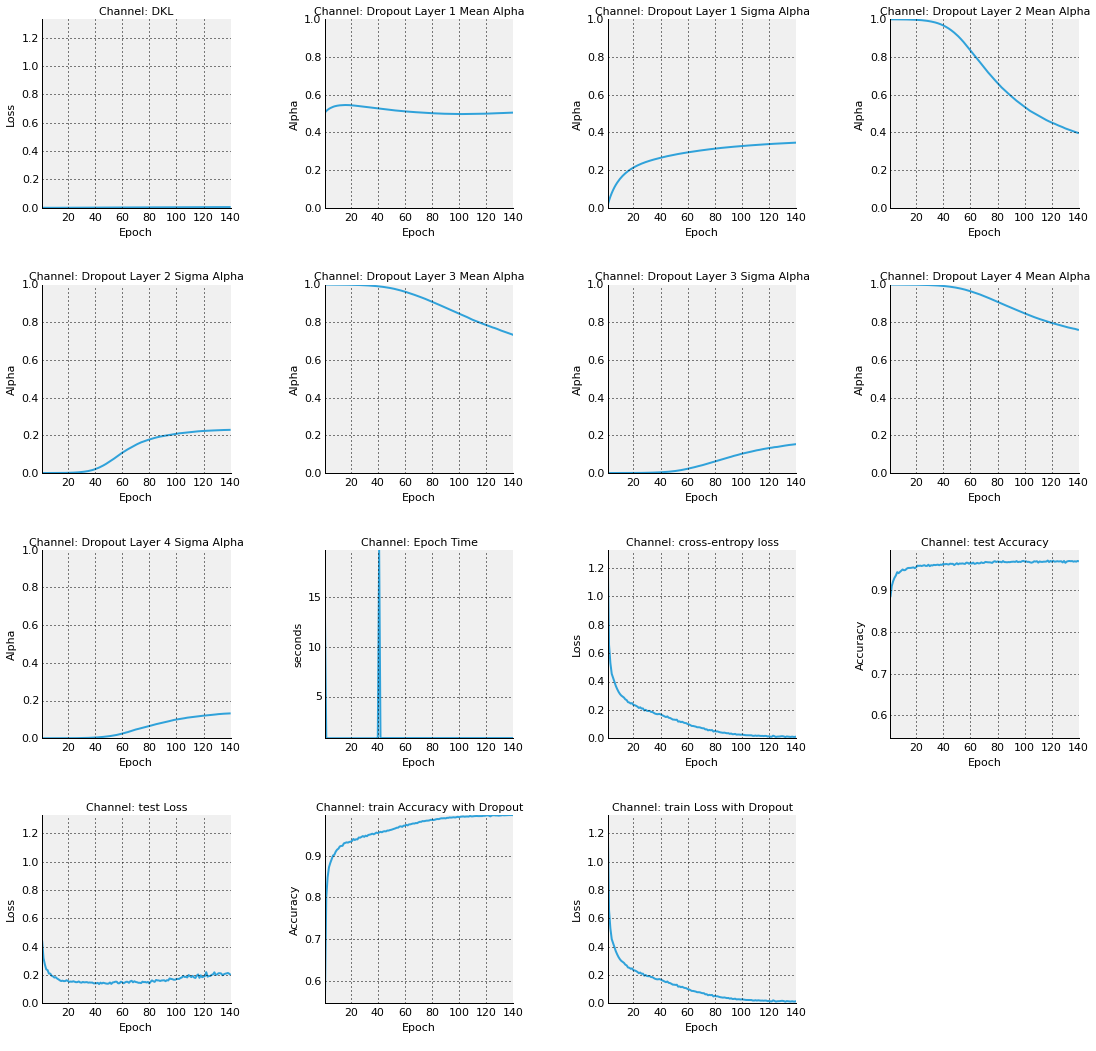

In [13]:
results = loop.run(100)
results.layout('Channel')

Looking at the alpha parameters learnt over the input image:

:Image   [x,y]   (z)
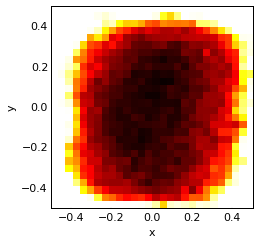

In [15]:
hv.Image(T.nnet.sigmoid(l_drop1.logitalpha).eval().reshape(28,28))

And comparing the filters learnt by their logitalpha scores:

In [20]:
filteralphas = T.nnet.sigmoid(l_drop2.logitalpha).eval()

In [21]:
filtermap = hv.HoloMap(kdims=['Alpha'])
for i,a in enumerate(filteralphas):
    filtermap[a] = hv.Image(l_hidden1.W.get_value()[:,i].reshape(28,28))

:NdLayout   [Alpha]
   :Image   [x,y]   (z)
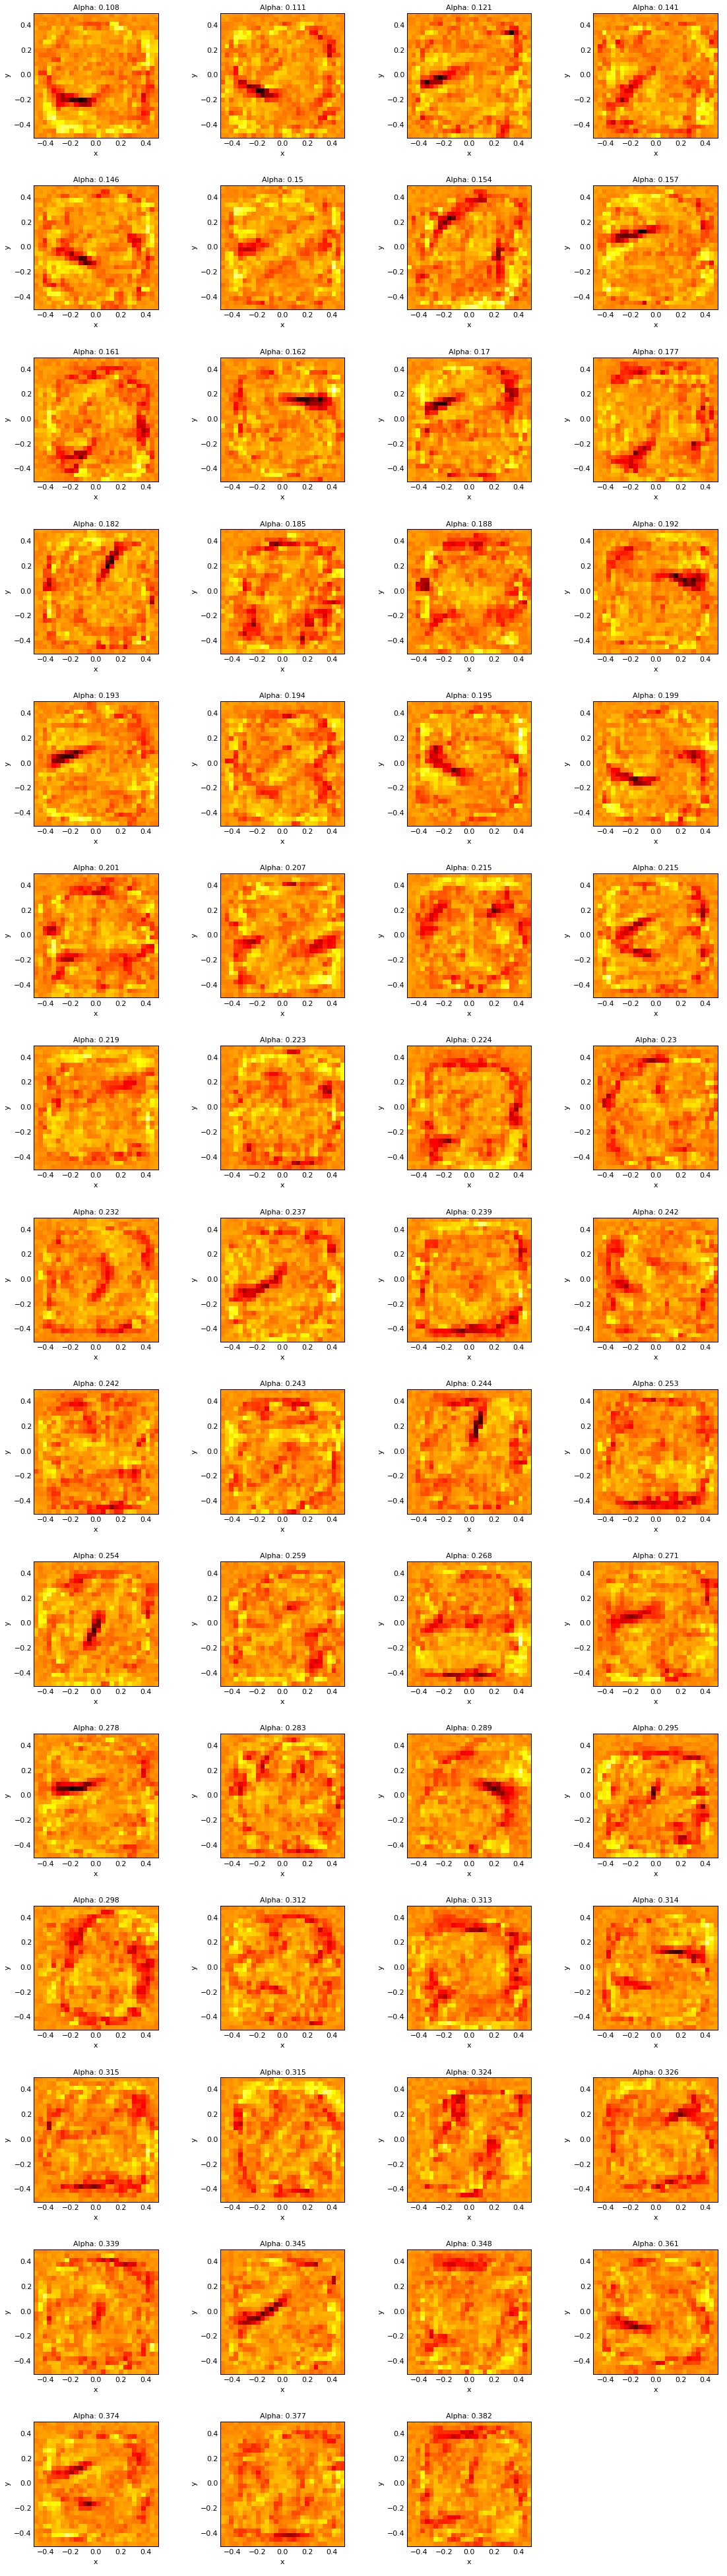

In [23]:
filtermap[:0.4].layout('Alpha')